In [1]:
pip install matplotlib


In [2]:
pip install keras 

Note: you may need to restart the kernel to use updated packages.


In [3]:

pip install numpy


In [4]:

pip install notebook

In [5]:
pip install tensorflow

In [7]:
pip install tensorflow-addons

In [8]:
pip install tensorflow-model-optimization

In [9]:
pip install tensorflow

In [10]:
import tensorflow as tf

In [11]:
from tensorflow.keras import models, layers

In [12]:
import matplotlib.pyplot as plt

In [13]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=25

In [14]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2000 files belonging to 5 classes.


In [15]:
class_names = dataset.class_names
class_names

['Bacterial Pneumonia',
 'Corona Virus Disease',
 'Normal',
 'Tuberculosis',
 'Viral Pneumonia']

In [16]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[4 2 4 3 3 4 2 0 4 1 1 1 2 3 0 0 4 3 1 3 0 3 1 2 1 2 4 4 1 2 1 4]


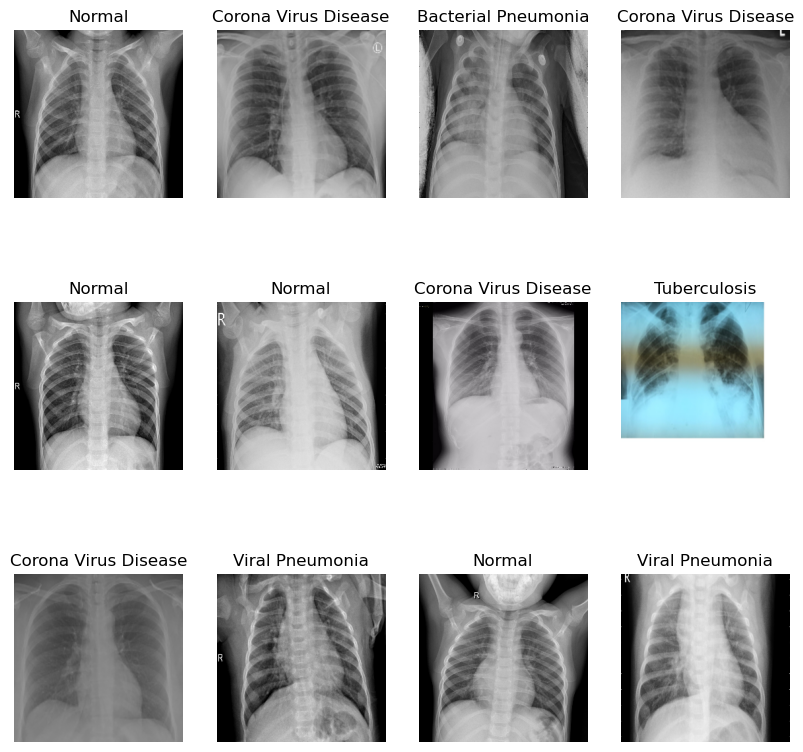

In [18]:
len(dataset)

63

In [19]:
train_size = 0.8
len(dataset)*train_size

50.400000000000006

In [20]:
train_ds = dataset.take(74)
len(train_ds)

63

In [21]:
test_ds = dataset.skip(74)
len(test_ds)

0

In [22]:
val_size=0.1
len(dataset)*val_size

6.300000000000001

In [23]:
val_ds = test_ds.take(9)
len(val_ds)

0

In [24]:
test_ds = test_ds.skip(9)
len(test_ds)

0

In [25]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [26]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [27]:
len(train_ds)

50

In [28]:
len(val_ds)

6

In [29]:
len(test_ds)

7

In [30]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [32]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [33]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,3,activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(128,3,activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256,activation="relu"),
    layers.Dense(len(class_names))
])

model.build(input_shape=input_shape)

In [35]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 115200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 256)                   │      29,491,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 5)                     │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,585,989 (112.86 MB)

 Trainable params: 29,585,989 (112.86 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [37]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.2924 - loss: 2.4410 - val_accuracy: 0.6458 - val_loss: 0.9582
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.5960 - loss: 0.9617 - val_accuracy: 0.7500 - val_loss: 0.6301
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.6809 - loss: 0.7716 - val_accuracy: 0.8073 - val_loss: 0.4952
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.7135 - loss: 0.7052 - val_accuracy: 0.7969 - val_loss: 0.5132
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.7291 - loss: 0.6627 - val_accuracy: 0.7865 - val_loss: 0.5464
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.7385 - loss: 0.6359 - val_accuracy: 0.8073 - val_loss: 0.5589
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.7209 - loss: 0.6934 - val_accuracy: 0.7656 - val_loss: 0.5616
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.7112 - loss: 0.6563 - val_accuracy: 0.8073 - v

In [38]:
scores = model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7406 - loss: 0.5653


In [39]:
scores

[0.5777994394302368, 0.7410714030265808]

In [40]:
history

In [41]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 50}

In [42]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [43]:
type(history.history['loss'])

list

In [44]:
len(history.history['loss'])

10

In [45]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.652263879776001,
 0.8930088877677917,
 0.737243115901947,
 0.7093248963356018,
 0.6795746684074402]

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [47]:
val_acc

[0.6458333134651184,
 0.75,
 0.8072916865348816,
 0.796875,
 0.7864583134651184,
 0.8072916865348816,
 0.765625,
 0.8072916865348816,
 0.8385416865348816,
 0.8125]

In [48]:

acc

[0.3958333432674408,
 0.6262626051902771,
 0.6944444179534912,
 0.7127525210380554,
 0.7234848737716675,
 0.7196969985961914,
 0.7291666865348816,
 0.7241161465644836,
 0.7348484992980957,
 0.7386363744735718]

In [ ]:
EPOCHS = 10

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Viral Pneumonia
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted label: Bacterial Pneumonia


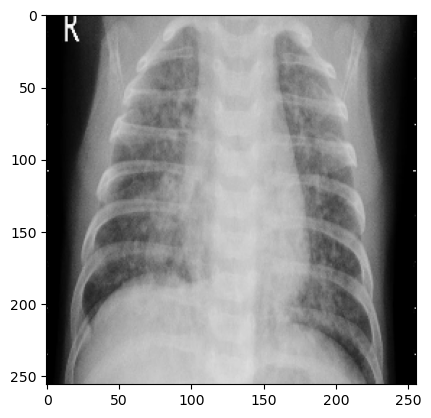

In [50]:
import numpy as np


for image_batch, label_batch in test_ds.take(5):
    first_image = image_batch[2].numpy().astype('uint8')
    first_label = int(label_batch[2].numpy())
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[2])])
    
    break

In [51]:
import tensorflow as tf
import numpy as np

def predict(model, img, class_names):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    # Normalize predictions to sum up to 1
    normalized_predictions = tf.nn.softmax(predictions)[0]

    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_index]
    confidence = round(100 * normalized_predictions[predicted_class_index].numpy(), 2)
    return predicted_class, confidence


In [1]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 30))

# Iterate through the test dataset
for images, labels in test_ds.take(1):  # Assuming `test_ds` is your test dataset
    # Iterate through a batch of images
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Predict the class and confidence for the current image
        predicted_class, confidence = predict(model, images[i], class_names)
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}, Confidence: {confidence}%")
        
        plt.axis("off")

plt.show()


NameError: name 'test_ds' is not defined

<Figure size 3000x3000 with 0 Axes>

In [58]:
import os 
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.export(f"../models/{model_version}")


INFO:tensorflow:Assets written to: ../models/5\assets


INFO:tensorflow:Assets written to: ../models/5\assets


Saved artifact at '../models/5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_3')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2133125826160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2133125826336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2133125828096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2133125829152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2133125828448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2133125830208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2133125829856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2133125830912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2133125829680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2133125831264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2133125830736: TensorSpec(shape=(), d

In [64]:
import keras
import tensorflow as tf
import numpy as np

In [65]:
pip install pyyaml h5py 

Note: you may need to restart the kernel to use updated packages.


In [67]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


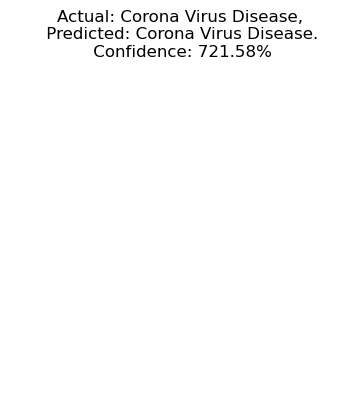

In [81]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds:
    for i in range(1):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        #print(predicted_class, confidence)
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")
    break